# Imports

In [1]:
import cudf as pd
import cupy
import dask
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import random

os.environ["KERAS_BACKEND"] = "jax"
import tensorflow as tf

from cuml import train_test_split
from cuml import RandomForestRegressor as CudaRandomForest
from cuml.svm import svr
from keras import Sequential
from keras.src.layers import Input, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    cupy.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


reset_seed()
dask.config.set(scheduler="threads", num_workers=30)



2024-07-27 01:55:52.237056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 01:55:52.237138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 01:55:52.244853: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 01:55:52.267538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 01:55:53.618881: W tensorflow/compiler/tf2

# Load Datasets



In [2]:
df_electricity_selected = pd.read_csv('./dataset/elect_merged_selected.csv', sep=";", decimal=",", header=0)
df_electricity_selected["date"] = pd.to_datetime(df_electricity_selected["date"], format="%Y-%m-%d")
df_electricity_selected.set_index("date", inplace=True)

df_climatic = pd.read_csv('dataset/climatic.csv', sep=";", decimal=",", header=0)
df_climatic["date"] = pd.to_datetime(df_climatic["date"], format="%d/%m/%Y")
df_climatic.set_index("date", inplace=True)

df_electricity_selected = df_electricity_selected.astype("float32")

x = df_electricity_selected.drop("consumption", axis=1)
y = df_electricity_selected["consumption"]


# Best Params

In [3]:
best = {}
for model in ["LSTM", "RF", "SVR", "XGB"]:
    df = pandas.DataFrame()
    for optimizer in ["GA", "PSO"]:
        for seed, name in [("1000", "A"), ("2000", "B"), ("3000", "C")]:
            df = pandas.concat([df,
                                pandas.read_csv(f'params/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";",
                                                decimal=",",
                                                header=0)], axis=0)
    df = df.sort_values(by=["Fitness"])
    df[df.isnull()] = None
    best[f"{model}"] = df[:1].iloc[0].to_dict()

# Prediction

## 1 Step

In [24]:
reset_seed()

#LSTM
tf.keras.backend.clear_session()
lstm_electricity = Sequential([
    Input((x.shape[1], 1)),
    LSTM(best["LSTM"]["Units"],
         activation=best["LSTM"]["Activation"],
         use_bias=best["LSTM"]["Bias"],
         seed=SEED),
    Dense(1),
])
lstm_electricity.compile(loss='mse')

#RF
rf_electricity = model = CudaRandomForest(random_state=SEED,
                                          n_estimators=best["RF"]["N_estimators"],
                                          max_depth=best["RF"]["Max_depth"],
                                          min_samples_split=best["RF"]["Min_samples_split"],
                                          min_samples_leaf=best["RF"]["Min_samples_leaf"],
                                          n_streams=1)

#SVR
svr_electricity = svr.SVR(C=best["SVR"]["C"],
                          epsilon=best["SVR"]["Epsilon"],
                          kernel=best["SVR"]["Kernel"])

#XGB
updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
xgb_electricity = XGBRegressor(device="cuda", random_state=SEED,
                               n_estimators=best["XGB"]["N_estimators"],
                               max_depth=best["XGB"]["Max_depth"],
                               booster=best["XGB"]["Booster"],
                               reg_lambda=best["XGB"]["Lambda"],
                               reg_alpha=best["XGB"]["Alpha"],
                               updater=updater)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1, shuffle=False)

for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_cupy().get(), x_train.iloc[i_test].to_cupy().get()
    ky_train, ky_test = y_train.iloc[i_train].to_cupy().get(), y_train.iloc[i_test].to_cupy().get()

    xgb_electricity.fit(kx_train, ky_train)
    rf_electricity.fit(kx_train, ky_train)
    svr_electricity.fit(kx_train, ky_train)
    lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
                         batch_size=best["LSTM"]["Batch Size"])

preds = {
    "LSTM": [],
    "RF": [],
    "SVR": [],
    "XGB": []
}

datasets = {
    "LSTM": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "RF": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "SVR": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "XGB": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1)
}

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].to_pandas()

    # Auxiliar array to  store the predictions for each model and update their lags
    sx_test_aux = {
        "LSTM": sx_test.copy(),
        "RF": sx_test.copy(),
        "SVR": sx_test.copy(),
        "XGB": sx_test.copy()
    }

    #Get the lags for each model based in the last prediction
    for model in ["LSTM", "RF", "SVR", "XGB"]:
        datasets[model] = pandas.concat([datasets[model], sx_test_aux[model]], axis=0)
        for lag in range(1, 12 + 1):
            if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
                sx_test_aux[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)
                datasets[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)

    #Appends prediction in array of each model
    pred = {"LSTM": lstm_electricity.predict(sx_test_aux["LSTM"].copy().to_numpy())[0][0],
            "RF": rf_electricity.predict(sx_test_aux["RF"].copy().to_numpy())[0],
            "SVR": svr_electricity.predict(sx_test_aux["SVR"].copy().to_numpy())[0],
            "XGB": xgb_electricity.predict(sx_test_aux["XGB"].copy().to_numpy())[0]}

    for model in ["LSTM", "RF", "SVR", "XGB"]:
        sx_test_aux[model]["consumption"] = pred[model]
        preds[model].append(pred[model])
        datasets[model].update(sx_test_aux[model])


/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)


1/1 [==============================] - 0s 162ms/step


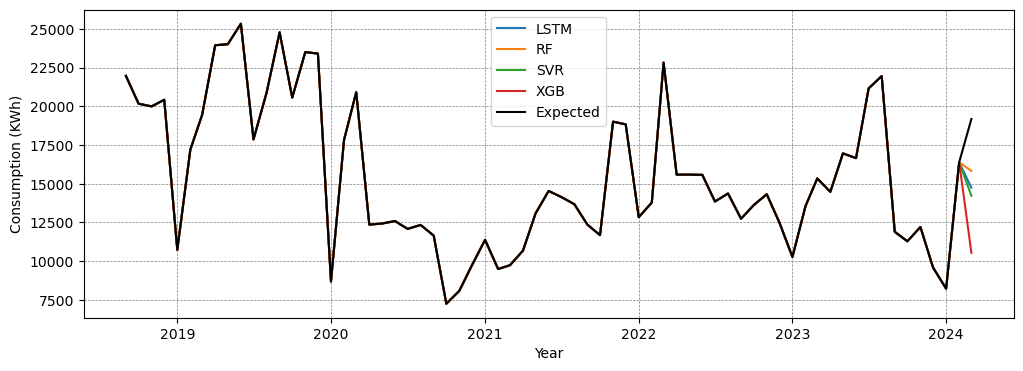

,LSTM,RF,SVR,XGB
MAE,4434.262695,3350.150391,4958.499023,8639.417969
MAPE,0.231168,0.174651,0.258498,0.450392


In [25]:
plt.figure(figsize=(12, 4))
df_measures_1 = pandas.DataFrame(index=["MAE", "MAPE"])

for model in ["LSTM", "RF", "SVR", "XGB"]:
    plt.plot(df_electricity_selected.index, np.concatenate((y_train.to_numpy(), preds[model])), label=model)
    df_measures_1[model] = pandas.Series([mean_absolute_error(y_test.to_numpy(), preds[model]),
                                          mean_absolute_percentage_error(y_test.to_numpy(), preds[model])],
                                         index=["MAE", "MAPE"])

plt.plot(df_electricity_selected["consumption"], label="Expected", color="black")

plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.savefig("results/Forecast Results for 3 Steps.png", bbox_inches='tight')
plt.show()

df_measures_1.to_csv(f"results/Measures 3 Steps.csv", sep=";", decimal=",", index=True)
df_measures_1

## 3 Steps

In [26]:
reset_seed()

#LSTM
tf.keras.backend.clear_session()
lstm_electricity = Sequential([
    Input((x.shape[1], 1)),
    LSTM(best["LSTM"]["Units"],
         activation=best["LSTM"]["Activation"],
         use_bias=best["LSTM"]["Bias"],
         seed=SEED),
    Dense(1),
])
lstm_electricity.compile(loss='mse')

#RF
rf_electricity = model = CudaRandomForest(random_state=SEED,
                                          n_estimators=best["RF"]["N_estimators"],
                                          max_depth=best["RF"]["Max_depth"],
                                          min_samples_split=best["RF"]["Min_samples_split"],
                                          min_samples_leaf=best["RF"]["Min_samples_leaf"],
                                          n_streams=1)

#SVR
svr_electricity = svr.SVR(C=best["SVR"]["C"],
                          epsilon=best["SVR"]["Epsilon"],
                          kernel=best["SVR"]["Kernel"])

#XGB
updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
xgb_electricity = XGBRegressor(device="cuda", random_state=SEED,
                               n_estimators=best["XGB"]["N_estimators"],
                               max_depth=best["XGB"]["Max_depth"],
                               booster=best["XGB"]["Booster"],
                               reg_lambda=best["XGB"]["Lambda"],
                               reg_alpha=best["XGB"]["Alpha"],
                               updater=updater)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=3, shuffle=False)

for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_cupy().get(), x_train.iloc[i_test].to_cupy().get()
    ky_train, ky_test = y_train.iloc[i_train].to_cupy().get(), y_train.iloc[i_test].to_cupy().get()

    xgb_electricity.fit(kx_train, ky_train)
    rf_electricity.fit(kx_train, ky_train)
    svr_electricity.fit(kx_train, ky_train)
    lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
                         batch_size=best["LSTM"]["Batch Size"])

preds = {
    "LSTM": [],
    "RF": [],
    "SVR": [],
    "XGB": []
}

datasets = {
    "LSTM": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "RF": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "SVR": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "XGB": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1)
}

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].to_pandas()

    # Auxiliar array to  store the predictions for each model and update their lags
    sx_test_aux = {
        "LSTM": sx_test.copy(),
        "RF": sx_test.copy(),
        "SVR": sx_test.copy(),
        "XGB": sx_test.copy()
    }

    #Get the lags for each model based in the last prediction
    for model in ["LSTM", "RF", "SVR", "XGB"]:
        datasets[model] = pandas.concat([datasets[model], sx_test_aux[model]], axis=0)
        for lag in range(1, 12 + 1):
            if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
                sx_test_aux[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)
                datasets[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)

    #Appends prediction in array of each model
    pred = {"LSTM": lstm_electricity.predict(sx_test_aux["LSTM"].copy().to_numpy())[0][0],
            "RF": rf_electricity.predict(sx_test_aux["RF"].copy().to_numpy())[0],
            "SVR": svr_electricity.predict(sx_test_aux["SVR"].copy().to_numpy())[0],
            "XGB": xgb_electricity.predict(sx_test_aux["XGB"].copy().to_numpy())[0]}

    for model in ["LSTM", "RF", "SVR", "XGB"]:
        sx_test_aux[model]["consumption"] = pred[model]
        preds[model].append(pred[model])
        datasets[model].update(sx_test_aux[model])


/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)


1/1 [==============================] - 0s 19ms/step


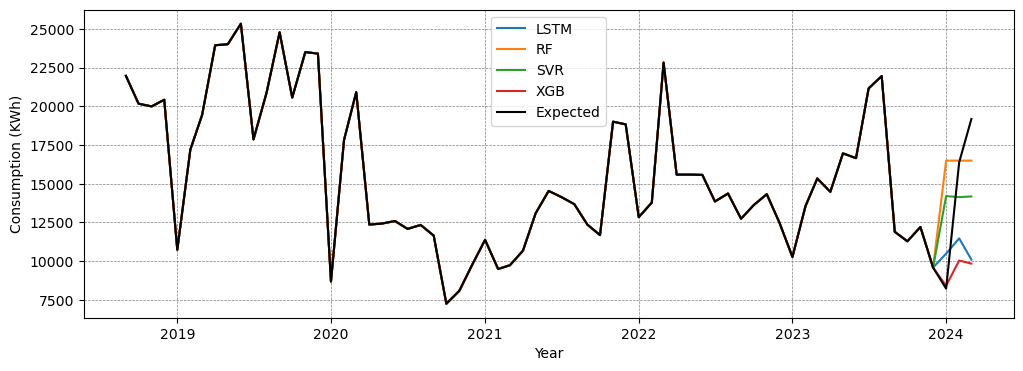

,LSTM,RF,SVR,XGB
MAE,5418.547363,3686.770752,4410.699219,5290.424316
MAPE,0.349345,0.383874,0.374993,0.298900


In [27]:
plt.figure(figsize=(12, 4))
df_measures_3 = pandas.DataFrame(index=["MAE", "MAPE"])

for model in ["LSTM", "RF", "SVR", "XGB"]:
    plt.plot(df_electricity_selected.index, np.concatenate((y_train.to_numpy(), preds[model])), label=model)
    df_measures_3[model] = pandas.Series([mean_absolute_error(y_test.to_numpy(), preds[model]),
                                          mean_absolute_percentage_error(y_test.to_numpy(), preds[model])],
                                         index=["MAE", "MAPE"])

plt.plot(df_electricity_selected["consumption"], label="Expected", color="black")

plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.savefig("results/Forecast Results for 3 Steps.png", bbox_inches='tight')
plt.show()

df_measures_3.to_csv(f"results/Measures 3 Steps.csv", sep=";", decimal=",", index=True)
df_measures_3

## 6 Steps

In [122]:
reset_seed()

#LSTM
tf.keras.backend.clear_session()
lstm_electricity = Sequential([
    Input((x.shape[1], 1)),
    LSTM(best["LSTM"]["Units"],
         activation=best["LSTM"]["Activation"],
         use_bias=best["LSTM"]["Bias"],
         seed=SEED),
    Dense(1),
])
lstm_electricity.compile(loss='mse')

#RF
rf_electricity = model = CudaRandomForest(random_state=SEED,
                                          n_estimators=best["RF"]["N_estimators"],
                                          max_depth=best["RF"]["Max_depth"],
                                          min_samples_split=best["RF"]["Min_samples_split"],
                                          min_samples_leaf=best["RF"]["Min_samples_leaf"],
                                          n_streams=1)

#SVR
svr_electricity = svr.SVR(C=best["SVR"]["C"],
                          epsilon=best["SVR"]["Epsilon"],
                          kernel=best["SVR"]["Kernel"])

#XGB
updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
xgb_electricity = XGBRegressor(device="cuda", random_state=SEED,
                               n_estimators=best["XGB"]["N_estimators"],
                               max_depth=best["XGB"]["Max_depth"],
                               booster=best["XGB"]["Booster"],
                               reg_lambda=best["XGB"]["Lambda"],
                               reg_alpha=best["XGB"]["Alpha"],
                               updater=updater)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=6, shuffle=False)

for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_cupy().get(), x_train.iloc[i_test].to_cupy().get()
    ky_train, ky_test = y_train.iloc[i_train].to_cupy().get(), y_train.iloc[i_test].to_cupy().get()

    xgb_electricity.fit(kx_train, ky_train)
    rf_electricity.fit(kx_train, ky_train)
    svr_electricity.fit(kx_train, ky_train)
    lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
                         batch_size=best["LSTM"]["Batch Size"])

preds = {
    "LSTM": [],
    "RF": [],
    "SVR": [],
    "XGB": []
}

datasets = {
    "LSTM": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "RF": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "SVR": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "XGB": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1)
}

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].to_pandas()

    # Auxiliar array to  store the predictions for each model and update their lags
    sx_test_aux = {
        "LSTM": sx_test.copy(),
        "RF": sx_test.copy(),
        "SVR": sx_test.copy(),
        "XGB": sx_test.copy()
    }

    #Get the lags for each model based in the last prediction
    for model in ["LSTM", "RF", "SVR", "XGB"]:
        datasets[model] = pandas.concat([datasets[model], sx_test_aux[model]], axis=0)
        for lag in range(1, 12 + 1):
            if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
                sx_test_aux[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)
                datasets[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)

    #Appends prediction in array of each model
    pred = {"LSTM": lstm_electricity.predict(sx_test_aux["LSTM"].copy().to_numpy())[0][0],
            "RF": rf_electricity.predict(sx_test_aux["RF"].copy().to_numpy())[0],
            "SVR": svr_electricity.predict(sx_test_aux["SVR"].copy().to_numpy())[0],
            "XGB": xgb_electricity.predict(sx_test_aux["XGB"].copy().to_numpy())[0]}

    for model in ["LSTM", "RF", "SVR", "XGB"]:
        sx_test_aux[model]["consumption"] = pred[model]
        preds[model].append(pred[model])
        datasets[model].update(sx_test_aux[model])


/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)


1/1 [==============================] - 0s 19ms/step


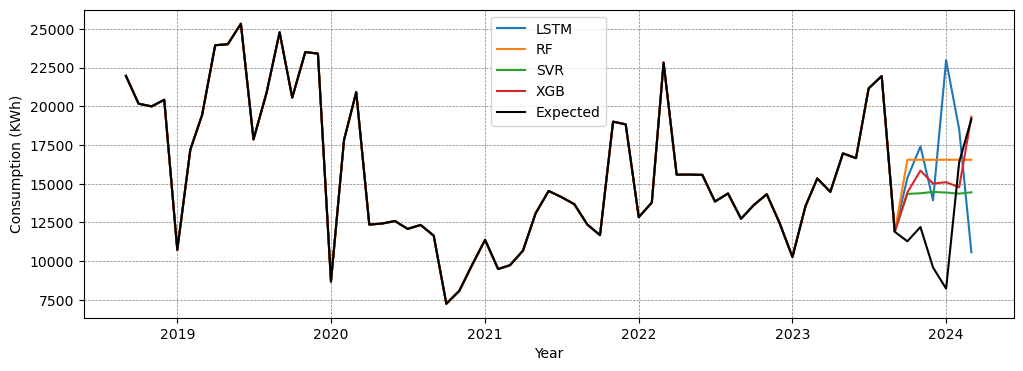

,LSTM,RF,SVR,XGB
MAE,6522.699219,4614.674316,3848.918945,3475.898438
MAPE,0.602498,0.451252,0.347370,0.347628


In [123]:
plt.figure(figsize=(12, 4))
df_measures_6 = pandas.DataFrame(index=["MAE", "MAPE"])

for model in ["LSTM", "RF", "SVR", "XGB"]:
    plt.plot(df_electricity_selected.index, np.concatenate((y_train.to_numpy(), preds[model])), label=model)
    df_measures_6[model] = pandas.Series([mean_absolute_error(y_test.to_numpy(), preds[model]),
                                          mean_absolute_percentage_error(y_test.to_numpy(), preds[model])],
                                         index=["MAE", "MAPE"])

plt.plot(df_electricity_selected["consumption"], label="Expected", color="black")

plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.savefig("results/Forecast Results for 6 Steps.png", bbox_inches='tight')
plt.show()

df_measures_6.to_csv(f"results/Measures 6 Steps.csv", sep=";", decimal=",", index=True)

df_measures_6

## 12 Steps

In [22]:
reset_seed()

#LSTM
tf.keras.backend.clear_session()
lstm_electricity = Sequential([
    Input((x.shape[1], 1)),
    LSTM(best["LSTM"]["Units"],
         activation=best["LSTM"]["Activation"],
         use_bias=best["LSTM"]["Bias"],
         seed=SEED),
    Dense(1),
])
lstm_electricity.compile(loss='mse')

#RF
rf_electricity = model = CudaRandomForest(random_state=SEED,
                                          n_estimators=best["RF"]["N_estimators"],
                                          max_depth=best["RF"]["Max_depth"],
                                          min_samples_split=best["RF"]["Min_samples_split"],
                                          min_samples_leaf=best["RF"]["Min_samples_leaf"],
                                          n_streams=1)

#SVR
svr_electricity = svr.SVR(C=best["SVR"]["C"],
                          epsilon=best["SVR"]["Epsilon"],
                          kernel=best["SVR"]["Kernel"])

#XGB
updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
xgb_electricity = XGBRegressor(device="cuda", random_state=SEED,
                               n_estimators=best["XGB"]["N_estimators"],
                               max_depth=best["XGB"]["Max_depth"],
                               booster=best["XGB"]["Booster"],
                               reg_lambda=best["XGB"]["Lambda"],
                               reg_alpha=best["XGB"]["Alpha"],
                               updater=updater)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=12, shuffle=False)

for i_train, i_test in TimeSeriesSplit(n_splits=5, test_size=1).split(x_train, y_train):
    kx_train, kx_test = x_train.iloc[i_train].to_cupy().get(), x_train.iloc[i_test].to_cupy().get()
    ky_train, ky_test = y_train.iloc[i_train].to_cupy().get(), y_train.iloc[i_test].to_cupy().get()

    xgb_electricity.fit(kx_train, ky_train)
    rf_electricity.fit(kx_train, ky_train)
    svr_electricity.fit(kx_train, ky_train)
    lstm_electricity.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
                         batch_size=best["LSTM"]["Batch Size"])

preds = {
    "LSTM": [],
    "RF": [],
    "SVR": [],
    "XGB": []
}

datasets = {
    "LSTM": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "RF": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "SVR": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1),
    "XGB": pandas.concat([x_train.to_pandas().copy(), y_train.to_pandas().copy()], axis=1)
}

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].to_pandas()

    # Auxiliar array to  store the predictions for each model and update their lags
    sx_test_aux = {
        "LSTM": sx_test.copy(),
        "RF": sx_test.copy(),
        "SVR": sx_test.copy(),
        "XGB": sx_test.copy()
    }

    #Get the lags for each model based in the last prediction
    for model in ["LSTM", "RF", "SVR", "XGB"]:
        datasets[model] = pandas.concat([datasets[model], sx_test_aux[model]], axis=0)
        for lag in range(1, 12 + 1):
            if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
                sx_test_aux[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)
                datasets[model][f'LAG_' + '{:02d}'.format(lag)] = datasets[model]["consumption"].shift(lag)

    #Appends prediction in array of each model
    pred = {"LSTM": lstm_electricity.predict(sx_test_aux["LSTM"].copy().to_numpy())[0][0],
            "RF": rf_electricity.predict(sx_test_aux["RF"].copy().to_numpy())[0],
            "SVR": svr_electricity.predict(sx_test_aux["SVR"].copy().to_numpy())[0],
            "XGB": xgb_electricity.predict(sx_test_aux["XGB"].copy().to_numpy())[0]}

    for model in ["LSTM", "RF", "SVR", "XGB"]:
        sx_test_aux[model]["consumption"] = pred[model]
        preds[model].append(pred[model])
        datasets[model].update(sx_test_aux[model])


/home/eduardo/miniconda3/envs/rapids-24.06/lib/python3.11/site-packages/cuml/internals/api_decorators.py:188: UserWarning: The number of bins, `n_bins` is greater than the number of samples used for training. Changing `n_bins` to number of training samples.
  ret = func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


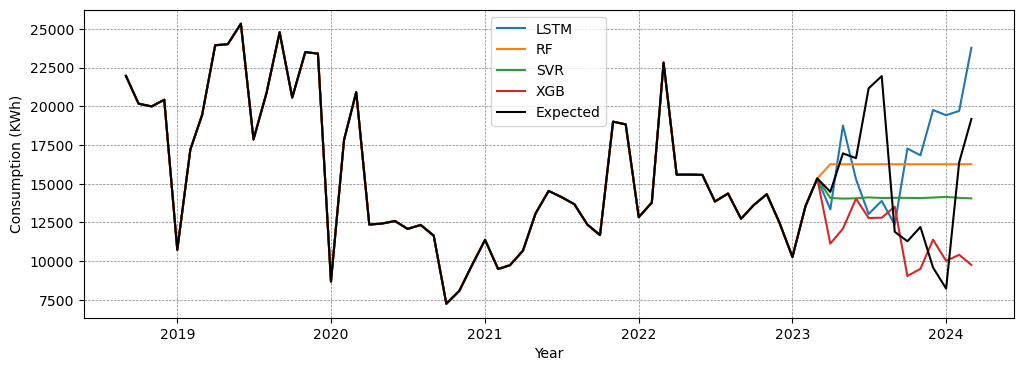

,LSTM,RF,SVR,XGB
MAE,5071.615723,3718.916748,3797.844727,4493.121094
MAPE,0.402644,0.304349,0.269386,0.275490


In [23]:
plt.figure(figsize=(12, 4))
df_measures_12 = pandas.DataFrame(index=["MAE", "MAPE"])

for model in ["LSTM", "RF", "SVR", "XGB"]:
    plt.plot(df_electricity_selected.index, np.concatenate((y_train.to_numpy(), preds[model])), label=model)
    df_measures_12[model] = pandas.Series([mean_absolute_error(y_test.to_numpy(), preds[model]),
                                           mean_absolute_percentage_error(y_test.to_numpy(), preds[model])],
                                          index=["MAE", "MAPE"])

plt.plot(df_electricity_selected["consumption"], label="Expected", color="black")

plt.xlabel('Year')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white')
plt.savefig("results/Forecast Results for 12 Steps.png", bbox_inches='tight')
plt.show()

df_measures_12.to_csv(f"results/Measures 12 Steps.csv", sep=";", decimal=",", index=True)
df_measures_12
